In [3]:
%matplotlib inline
import matplotlib as mpl
mpl.style.use('/Users/nik/Dropbox/Notebooks/thesisrc.py')
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import pandas as pd
import lvdatatools as lvdt

In [5]:
root = '/Volumes/JUPITER/Data/'
os.chdir(root)
data_dir = os.path.join(root,'scfmh8/')
figure_dir = os.path.join(root,'scfmh8/figures/')
thesis_dir = '/Users/nik/Dropbox/Repos/thesis/figures/scfmdots'

In [6]:
filelist = glob.glob(data_dir+'*.bin')
filelist.sort(key=lambda f: f[len(data_dir):-4].lower())
for f in filelist:
    print '\'{0}\''.format(f[len(data_dir):]), '{:0.1f}MB'.format(os.path.getsize(f)/1e6)

'cooldown_4-1-6_0T_a.bin' 0.2MB
'fieldswp_15-16-6_4K_d.bin' 0.2MB
'fieldswp_15-16-6_4K_e.bin' 0.0MB
'fieldswp_15-16-6_4K_f.bin' 0.0MB
'fieldswp_15-16-6_4K_h.bin' 0.2MB
'fieldswp_16-15-6_4K_k.bin' 0.0MB
'fieldswp_16-15-6_4K_m.bin' 0.3MB
'fieldswp_16-15-6_4K_n.bin' 0.3MB
'fieldswp_2-1-6_4K_a.bin' 0.2MB
'fieldswp_4-2-6_4K_a.bin' 0.0MB
'fieldswp_4-2-6_4K_b.bin' 0.0MB
'fieldswp_4-2-6_4K_c.bin' 0.0MB
'gateswp_16-15-6_0T_4K_a.bin' 0.0MB
'gateswp_4-1-6_0T_4K_a.bin' 0.0MB
'gateswp_4-1-6_0T_4K_b.bin' 0.0MB
'vi_16-15-6_4K_0T_a.bin' 0.0MB
'vifield_15-16-6_4K_c.bin' 0.3MB
'vifield_15-16-6_4K_d.bin' 0.2MB
'vifield_16-15-6_4K_a.bin' 0.3MB
'vifield_16-15-6_4K_b.bin' 0.0MB
'vifield_2-1-6_4K_a.bin' 0.2MB


# Device Images

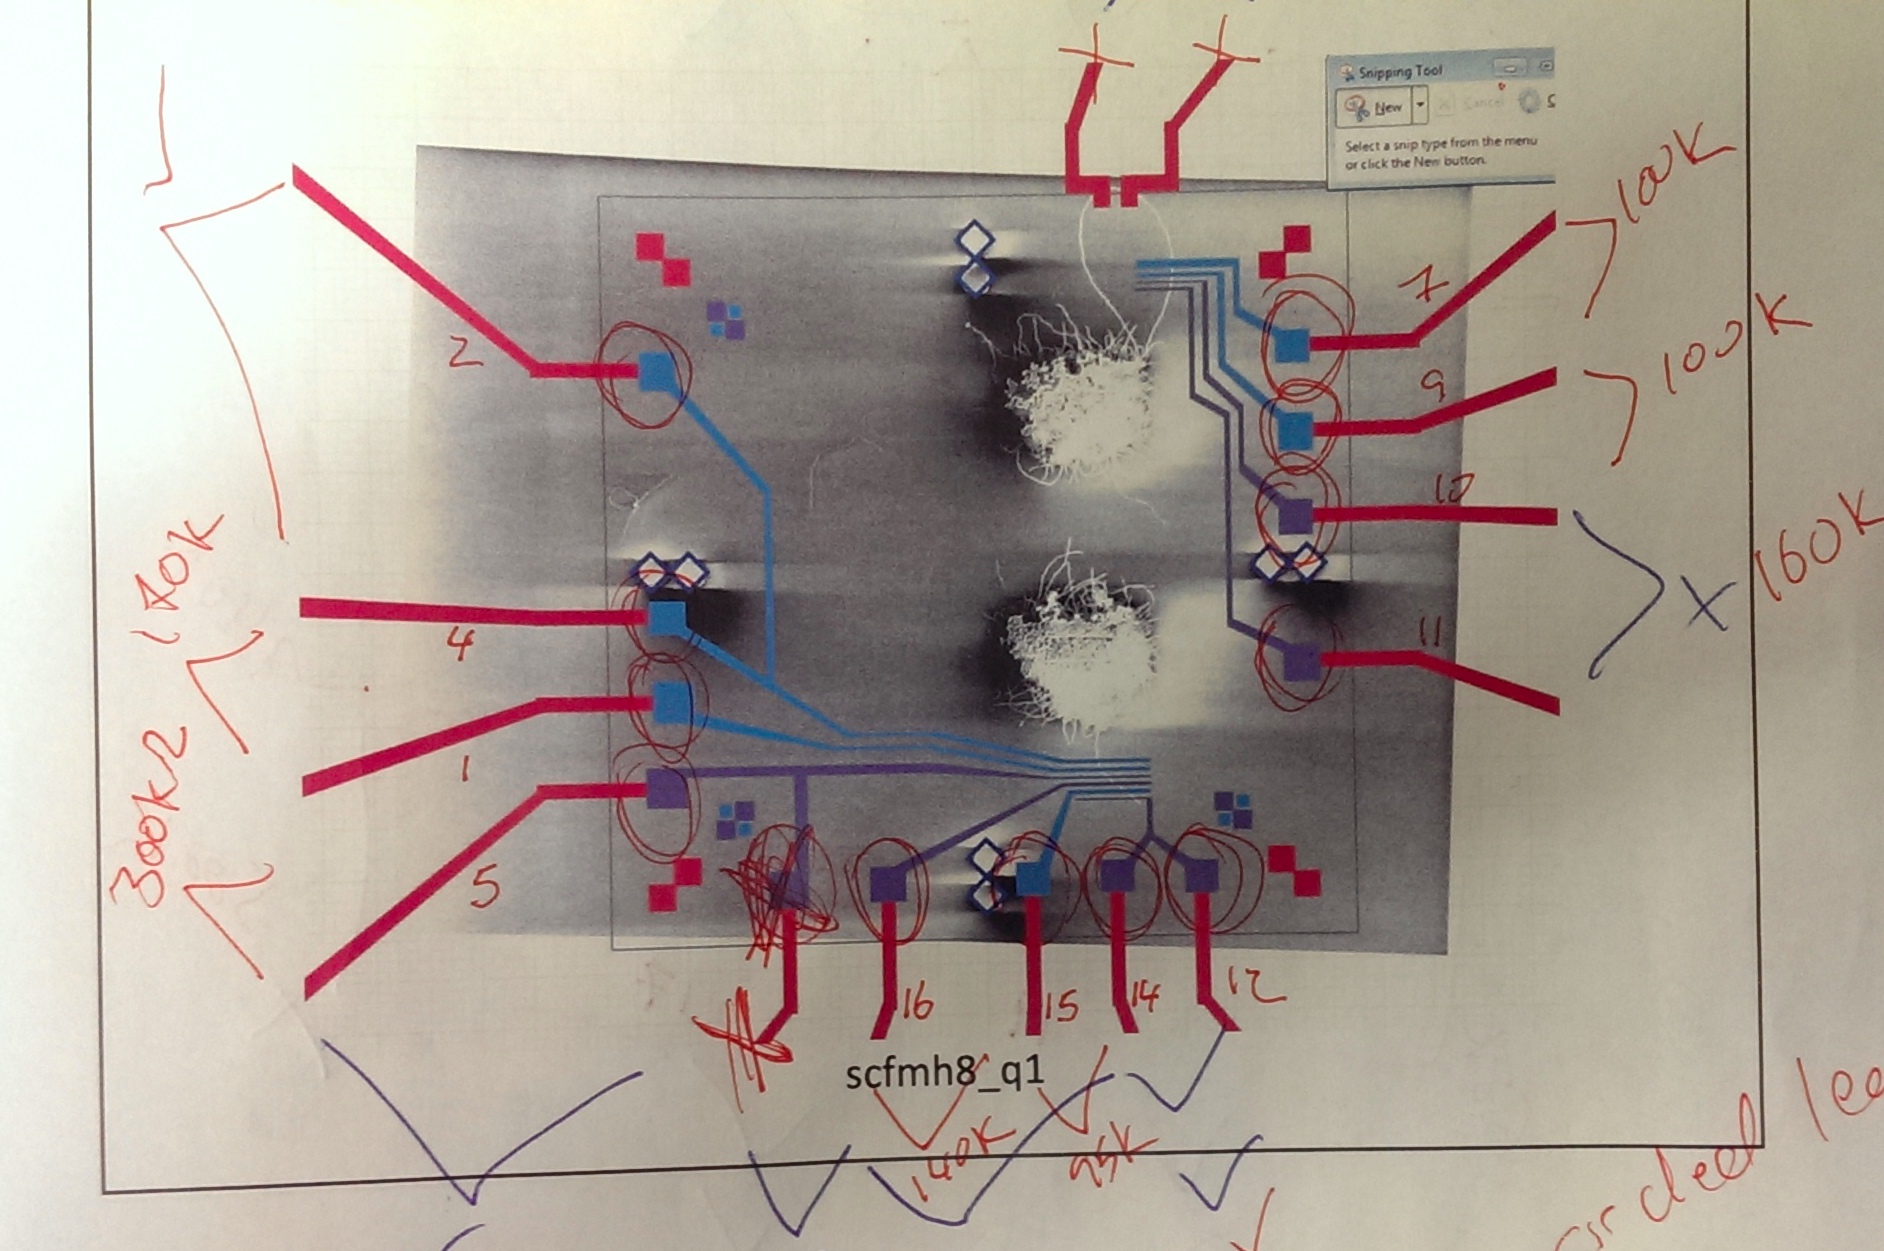

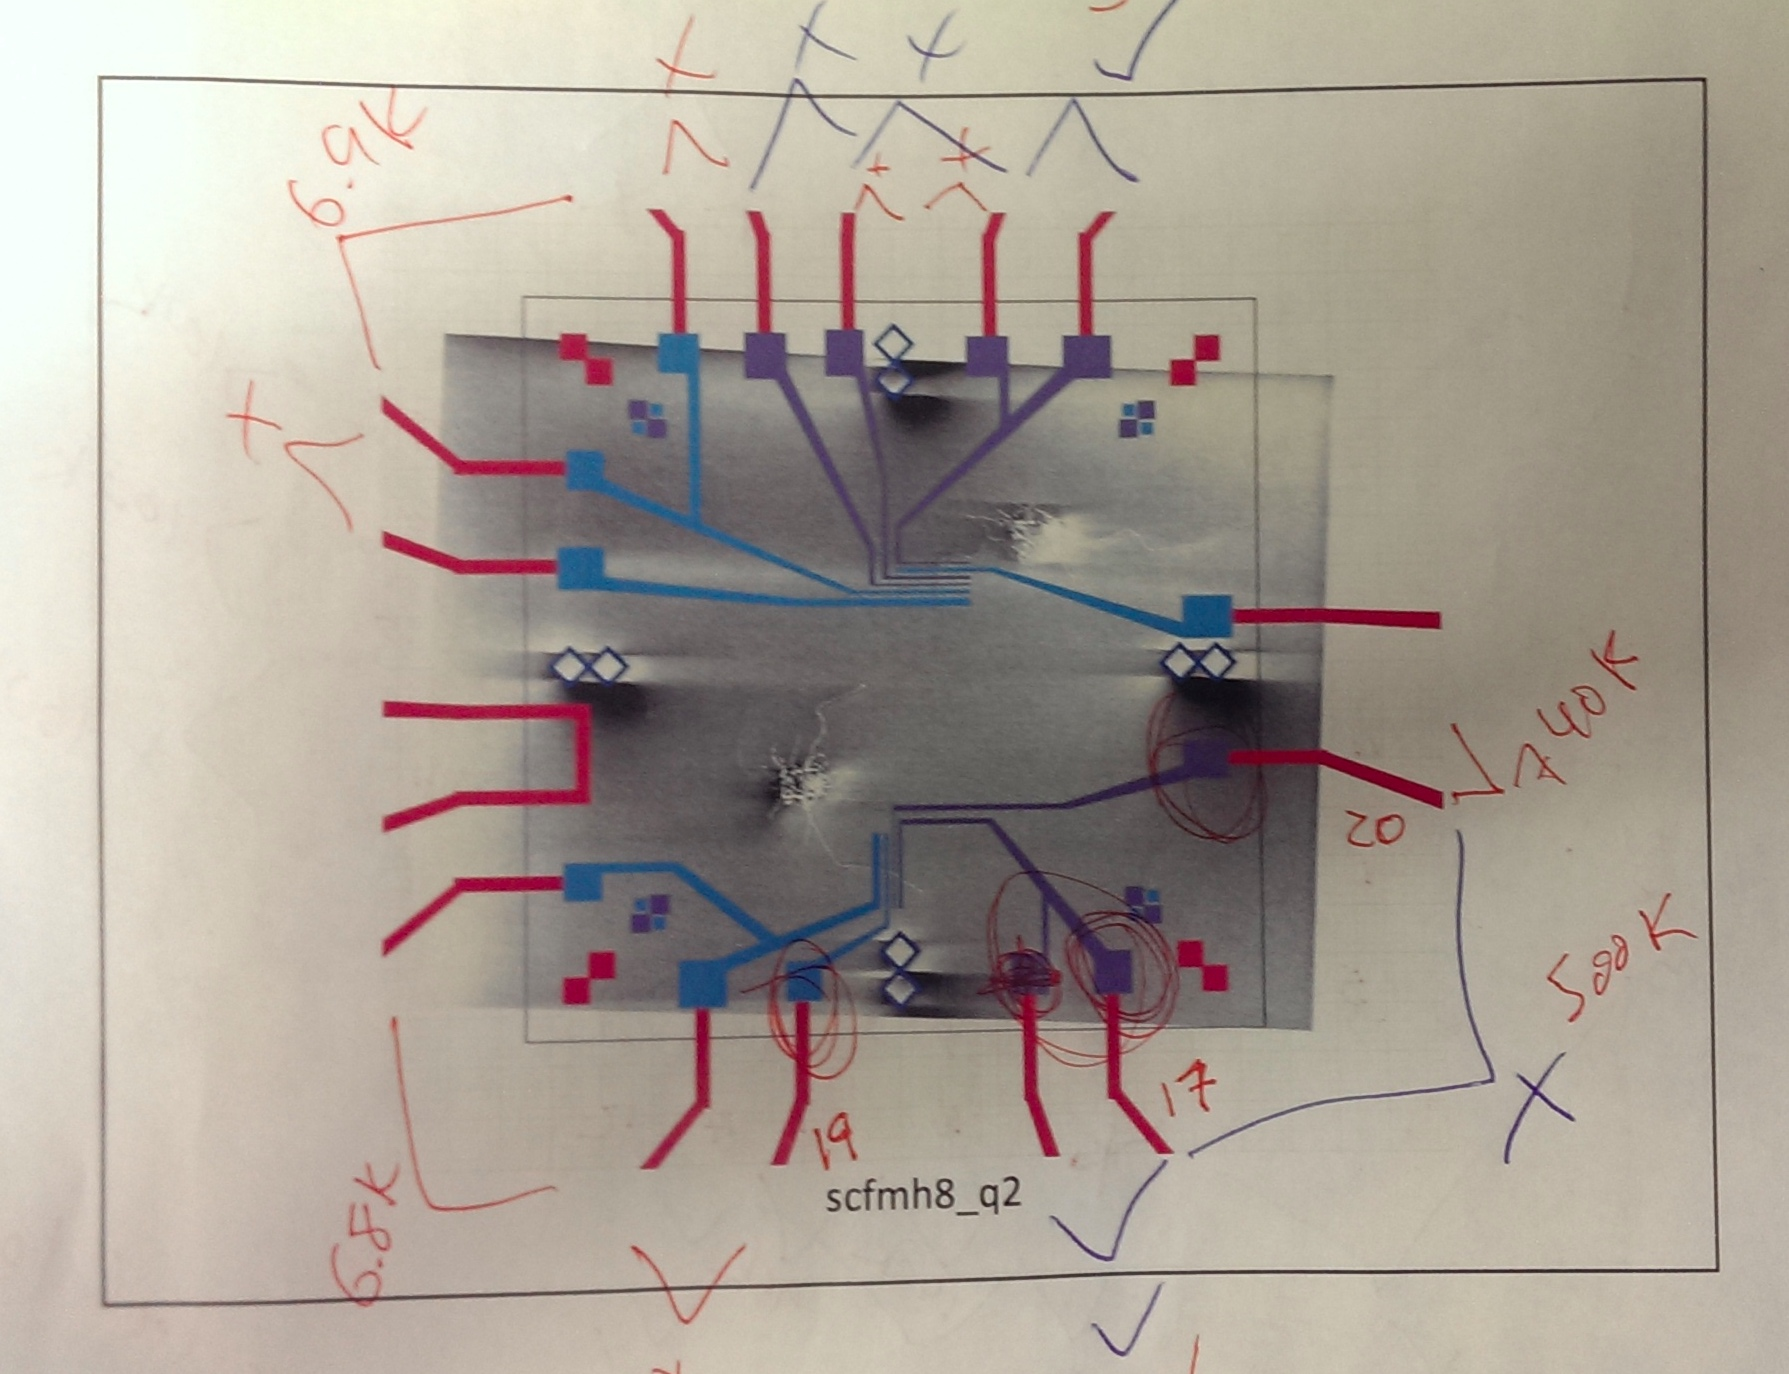

In [7]:
from IPython.display import display, Image 

display(Image(figure_dir+'scfmh8_q1.jpg', width=500))
display(Image(figure_dir+'scfmh8_q2.jpg', width=500))

The blue leads are Nb, purple leads are Py. The red handwritten numbers are the same referenced in the seciton headings in this document. This thing is in the dunker/Reich lab magnet. The magnetic field points from right to left.

# 4-1 Nb/Nb

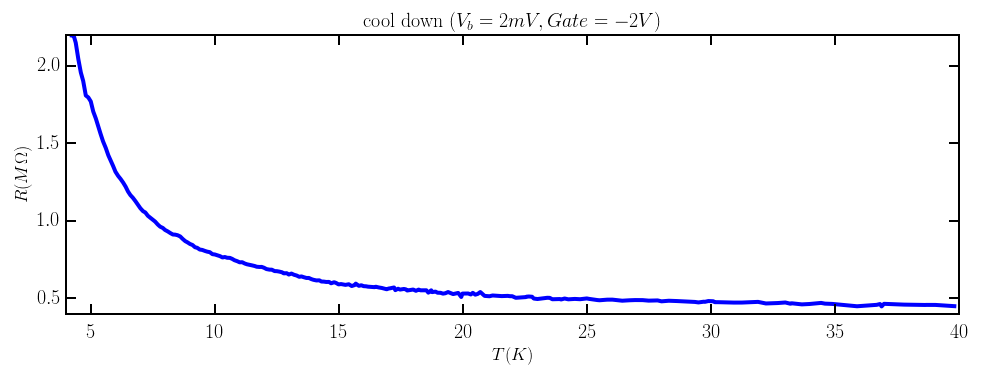

In [15]:
f = data_dir + 'cooldown_4-1-6_0T_a.bin'

df = lvdt.get_data_2d(f)
df = df[df['T'] < 40.0]

df = df.groupby(df['T'].apply(np.round, decimals=1)).mean()

#df = df[df['Iavg'] > 0.0]
df.sort('T', inplace=True)

bias = 2.5e-3

fig = plt.figure(figsize=(16,5))

ax = fig.add_subplot(1,1,1)
ax.plot(df['T'], (bias/df['Iavg'])/1e6, label='cool down')
ax.set_xlim(4,40)
#ax.set_yscale('log')
#ax.set_ylim(0.5e6,0.5e8)
ax.set_title(r'cool down ($V_b = 2mV, Gate = -2V$)')
ax.set_xlabel(r'$T (K)$')
ax.set_ylabel(r'$R (M\Omega)$')
# ax.legend(fontsize = 18)

Somewhere in there is a superconducting transition.

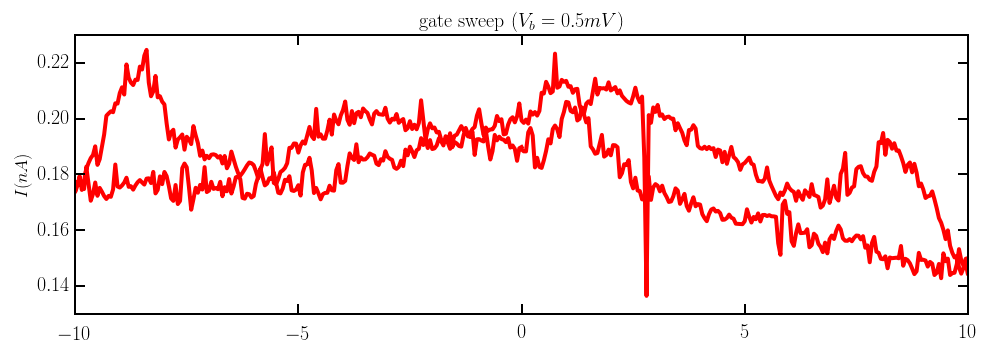

In [17]:
f = data_dir+'gateswp_4-1-6_0T_4K_a.bin'

gateswp = lvdt.get_data_2d(f)

fig = plt.figure(figsize=(16,5))

ax = fig.add_subplot(1,1,1)
ax.plot(gateswp['Gate'], gateswp['Iavg']*1e9, c = 'r')
#ax.set_xlim(0.5,3.5)
#ax.set_ylim(0.05,0.2)
ax.set_title('gate sweep ($V_b = 0.5mV$)')
ax.set_ylabel('$I (nA)$')
#ax.legend()

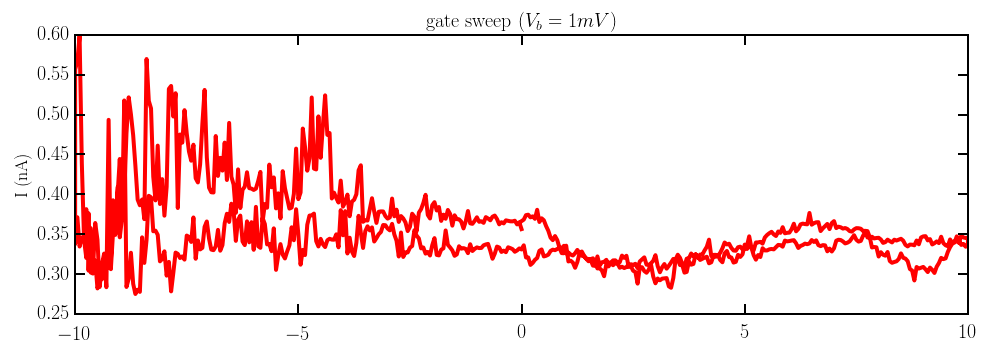

In [18]:
f = data_dir+'gateswp_4-1-6_0T_4K_b.bin'

gateswp = lvdt.get_data_2d(f)

fig = plt.figure(figsize=(16,5))

ax = fig.add_subplot(1,1,1)
ax.plot(gateswp['Gate'], gateswp['Iavg']*1e9, c = 'r')
#ax.set_xlim(0.5,3.5)
#ax.set_ylim(0.05,0.2)
ax.set_title('gate sweep ($V_b = 1mV$)')
ax.set_ylabel('I (nA)')
#ax.legend()

Looks a lot like the gate sweeps on the last sample. Maybe there is something wrong with the wiring on the dunker. I did have to solder a lot of things back together to set this up. I checked it a few times, but maybe I missed something. 

NOTE: I just tried to check the superconducting transition using the heater on the sample holder. The heater is shorted to the sample I'm measuring in some way. That might be related to my gate problems. 

Yeah. The heater is definitely connected to my nanotube. Damn. That's pretty messed up.

# 16-15 Py/Nb

Here's a bunch of functions that are going to be useful in a minute

In [19]:
def get_indices(data):
    """ takes a set of data and returns all of """
    start = 0 #index to start reading
    inds = [start]
    while start<len(data): 
        length = data[start] # first element in the set is the length
        end = start+length # last index in data set
        inds.append(end)
        start = end
    return inds

In [20]:
def get_padded_df(data, slow):
    """ pad different length data sets with np.inf (to be consistent
        with my LabView script) to create a rectangular numpy array 
        with each data set in it's own row 
        
        data: 1D array read from the binary file
        slow: slow scan axis name like 'bias', 'gate', ... """
    
    inds = get_indices(data)
    lengths = np.diff(inds)
    max_length = max(lengths)
    
    val = np.inf
    out = np.zeros((len(lengths),max(lengths)))
    for i in range(len(lengths)):
        out[i] = np.append(data[inds[i]:inds[i+1]], np.zeros(max_length-lengths[i])+val)
    col_names = ['size', slow]
    col_names.extend([str(n) for n in range(int(max_length-2))])
    return pd.DataFrame(out[:,1:], columns = col_names[1:])

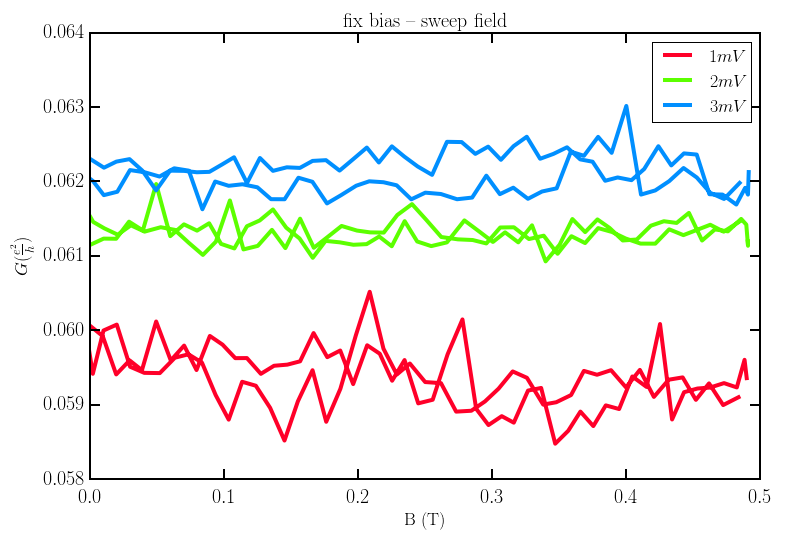

In [25]:
# this data set was really just a test to make sure I could read all the data 
# it's not great, but it works

f = data_dir+'fieldswp_16-15-6_4K_k.bin'
data = np.fromfile(f, '>d') # big-endian double point floats

bibias = get_padded_df(data, 'bias')

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)

values = np.linspace(0, 1, len(bibias)/2)
cm = plt.get_cmap('gist_rainbow')
ax.set_color_cycle([cm(v) for v in values])

for i in range(0, len(bibias), 2):
    bias = bibias['bias'][i]
    field = bibias.loc[i][1:]
    current = bibias.loc[i+1][1:]
    if bias==0.0: #sloppy but fine here
        continue
    ax.plot(field, (current/bias)/(3.875e-5), label = '${0:.0f} mV$'.format(bias*1000))
ax.set_xlim(0,0.5)
#ax.set_ylim(0.05,0.2)
ax.set_title('fix bias -- sweep field')
ax.set_ylabel(r'$G (\frac{e^2}{h})$')
ax.set_xlabel('B (T)')
ax.legend(fontsize = 18)

In [26]:
# figure out how to split that data further into up and down sweeps (also padded to the same length)
# figure out how to put this mess into a color plot

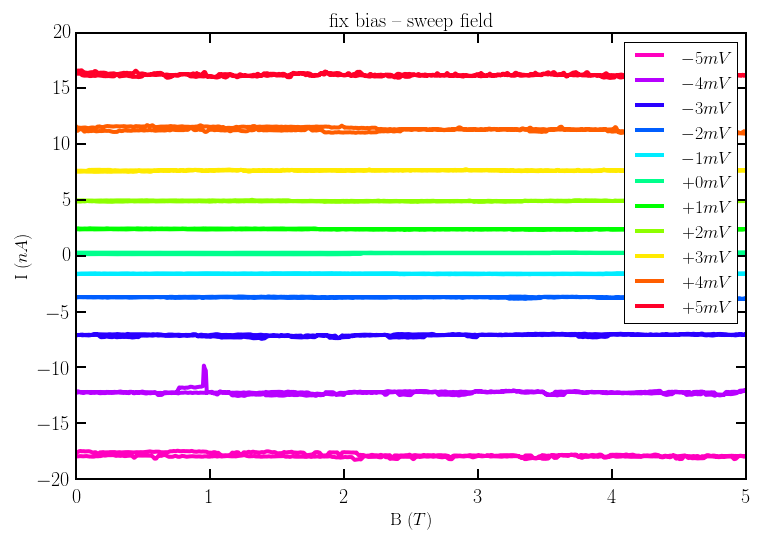

In [29]:
f = data_dir+'fieldswp_16-15-6_4K_m.bin'
data = np.fromfile(f, '>d') # big-endian double point floats

bibias = get_padded_df(data, 'bias')

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)

values = np.linspace(1, 0, len(bibias)/2)
cm = plt.get_cmap('gist_rainbow')
ax.set_color_cycle([cm(v) for v in values])

for i in range(0, len(bibias), 2):
    bias = bibias['bias'][i]
    field = pd.rolling_mean(bibias.loc[i][1:], 3)
    current = pd.rolling_mean(bibias.loc[i+1][1:], 3)
    ax.plot(field, current*1e9, label = r'${0:+.0f} mV$'.format(bias*1000))
ax.set_xlim(0,5)
#ax.set_ylim(0.05,0.2)
ax.set_title('fix bias -- sweep field')
ax.set_ylabel('I $(nA)$')
ax.set_xlabel('B $(T)$')
ax.legend(fontsize = 18)

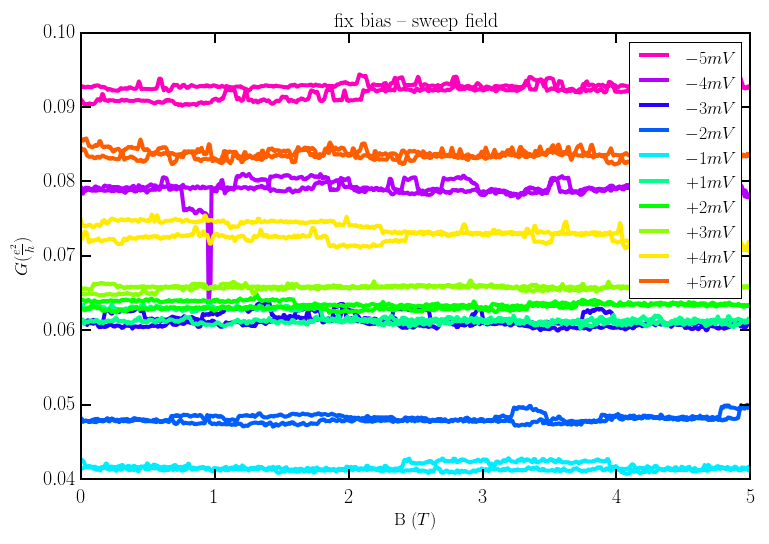

In [30]:
f = data_dir+'fieldswp_16-15-6_4K_m.bin'
data = np.fromfile(f, '>d') # big-endian double point floats

bibias = get_padded_df(data, 'bias')

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)

values = np.linspace(1, 0, len(bibias)/2)
cm = plt.get_cmap('gist_rainbow')
ax.set_color_cycle([cm(v) for v in values])

for i in range(0, len(bibias), 2):
    bias = bibias['bias'][i]
    field = pd.rolling_mean(bibias.loc[i][1:], 3)
    current = pd.rolling_mean(bibias.loc[i+1][1:], 3)
    if bias==0.0: #sloppy but fine here
        continue
    ax.plot(field, (current/bias)/(3.875e-5), label = r'${0:+.0f} mV$'.format(bias*1000))
ax.set_xlim(0,5)
#ax.set_ylim(0.05,0.2)
ax.set_title('fix bias -- sweep field')
ax.set_ylabel(r'$G (\frac{e^2}{h})$')
ax.set_xlabel('B $(T)$')
ax.legend(fontsize = 18)

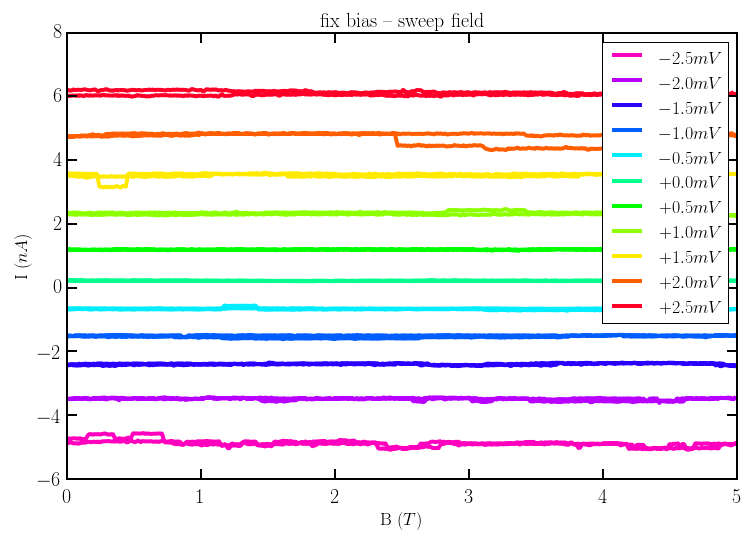

In [32]:
f = data_dir+'fieldswp_16-15-6_4K_n.bin'
data = np.fromfile(f, '>d') # big-endian double point floats

bibias = get_padded_df(data, 'bias')

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)

values = np.linspace(1, 0, len(bibias)/2)
cm = plt.get_cmap('gist_rainbow')
ax.set_color_cycle([cm(v) for v in values])

for i in range(0, len(bibias), 2):
    bias = bibias['bias'][i]
    field = pd.rolling_mean(bibias.loc[i][1:], 3)
    current = pd.rolling_mean(bibias.loc[i+1][1:], 3)
    ax.plot(field, current*1e9, label = r'${0:+.1f} mV$'.format(bias*1000))
ax.set_xlim(0,5)
#ax.set_ylim(0.05,0.2)
ax.set_title('fix bias -- sweep field')
ax.set_ylabel('I $(nA)$')
ax.set_xlabel('B $(T)$')
ax.legend(fontsize = 18)

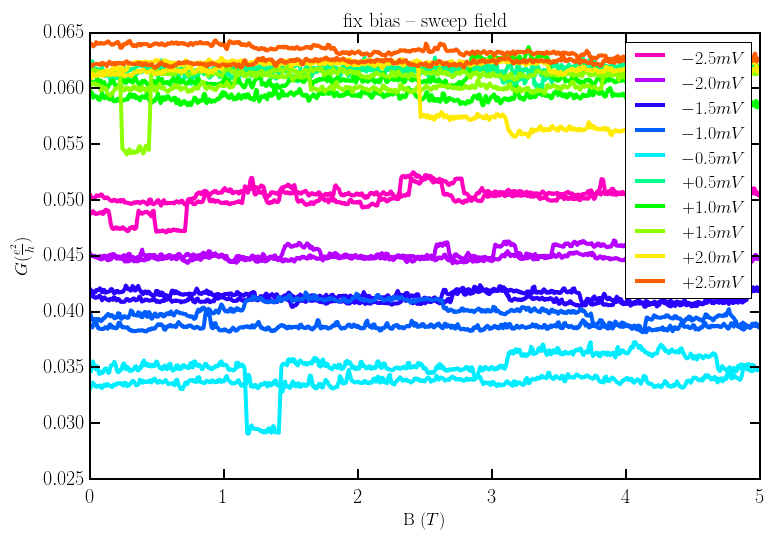

In [36]:
f = data_dir+'fieldswp_16-15-6_4K_n.bin'
data = np.fromfile(f, '>d') # big-endian double point floats

bibias = get_padded_df(data, 'bias')

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)

values = np.linspace(1, 0, len(bibias)/2)
cm = plt.get_cmap('gist_rainbow')
ax.set_color_cycle([cm(v) for v in values])

for i in range(0, len(bibias), 2):
    bias = bibias['bias'][i]
    field = pd.rolling_mean(bibias.loc[i][1:], 3)
    current = pd.rolling_mean(bibias.loc[i+1][1:], 3)
    if bias==0.0: #sloppy but fine here
        continue
    ax.plot(field, (current/bias)/(3.875e-5), label = r'${0:+.1f} mV$'.format(bias*1000))
ax.set_xlim(0,5)
#ax.set_ylim(0.05,0.2)
ax.set_title('fix bias -- sweep field')
ax.set_ylabel(r'$G (\frac{e^2}{h})$')
ax.set_xlabel('B $(T)$')
ax.legend(fontsize = 18)

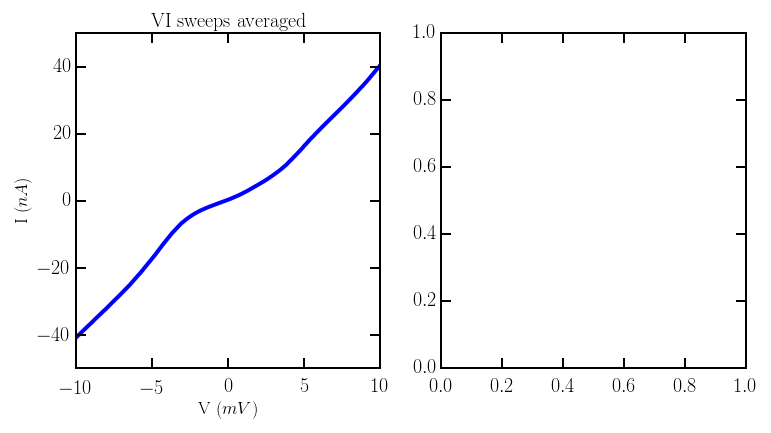

In [10]:
f = data_dir+'vi_16-15-6_4K_0T_a.bin'

vi = lvdt.get_data_3d(f)
vi = vi.groupby(vi.index).mean()

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,6))

ax1.plot(vi.index*1e3, vi.mean(axis=1)*1e9)
#ax.set_xlim(0,5)
#ax.set_ylim(0.05,0.2)
ax1.set_title('VI sweeps averaged')
ax1.set_ylabel('I $(nA)$')
ax1.set_xlabel('V $(mV)$')
#ax.legend()

f = data_dir+'vi_16-15-6_4K_0T_a.bin'

vi = lvdt.get_data_3d(f)
vi = vi.groupby(vi.index).mean()
dvdi = vi.mean(axis=1).diff()

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(dvdi.index*1e3, (dvdi/100e-6)/3.875e-5)
#ax.set_xlim(0,5)
#ax.set_ylim(0.05,0.2)
ax.set_title('VI sweeps')
ax.set_ylabel(r'$G (\frac{e^2}{h})$')
ax.set_xlabel('V $(mV)$')
#ax.legend()

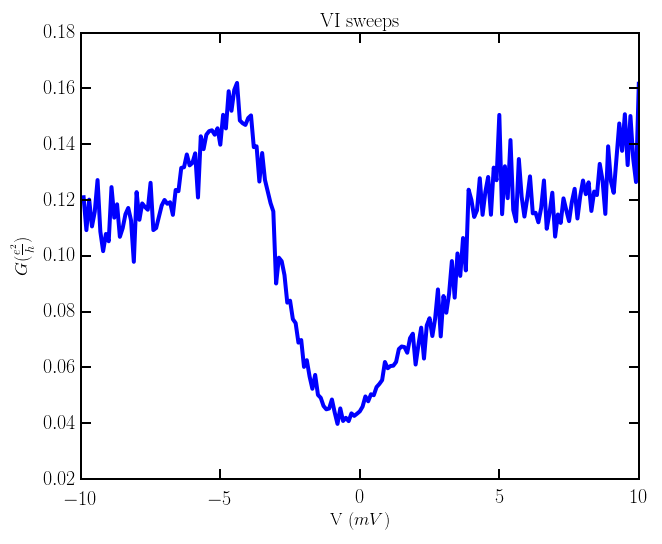

In [39]:
f = data_dir+'vi_16-15-6_4K_0T_a.bin'

vi = lvdt.get_data_3d(f)
vi = vi.groupby(vi.index).mean()
dvdi = vi.mean(axis=1).diff()

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(dvdi.index*1e3, (dvdi/100e-6)/3.875e-5)
#ax.set_xlim(0,5)
#ax.set_ylim(0.05,0.2)
ax.set_title('VI sweeps')
ax.set_ylabel(r'$G (\frac{e^2}{h})$')
ax.set_xlabel('V $(mV)$')
#ax.legend()

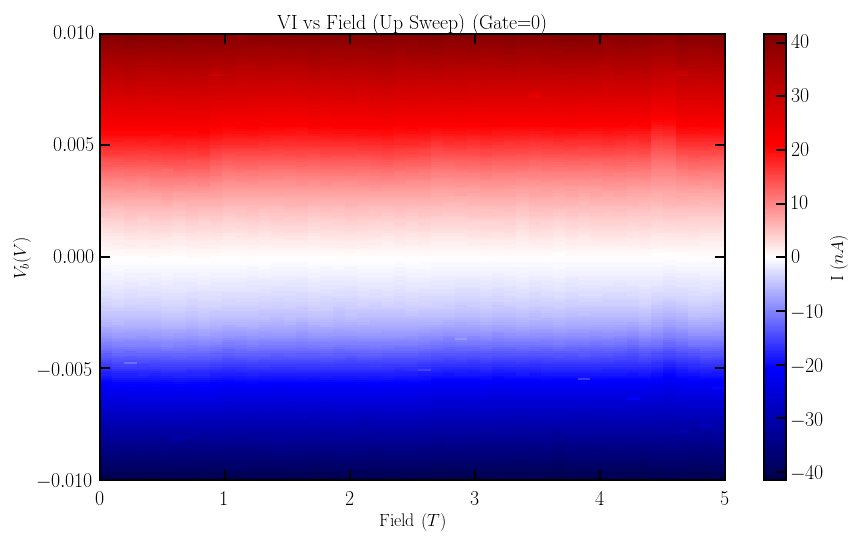

In [47]:
f = data_dir+'vifield_16-15-6_4K_a.bin'

vifield = lvdt.get_data_3d(f)
vifield = vifield.groupby(vifield.index).mean()

fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(1,1,1)
limits = lvdt.df_extent(vifield)
im = ax.imshow(vifield.iloc[:,0:51]*1e9, extent = limits, 
           cmap = plt.cm.seismic, #vmin = -12, vmax = 12,
           origin = 'lower', aspect = 'auto', interpolation = 'None')
ax.set_title('VI vs Field (Up Sweep) (Gate=0)')
ax.set_xlabel('Field $(T)$')
ax.set_ylabel(r'$V_b (V)$')
cb = plt.colorbar(im)
cb.set_label('I $(nA)$')

In [46]:
vifield = lvdt.get_data_3d(f)
vifield.columns[0:53]

Float64Index([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5.0, 5.0, 4.9], dtype='float64')

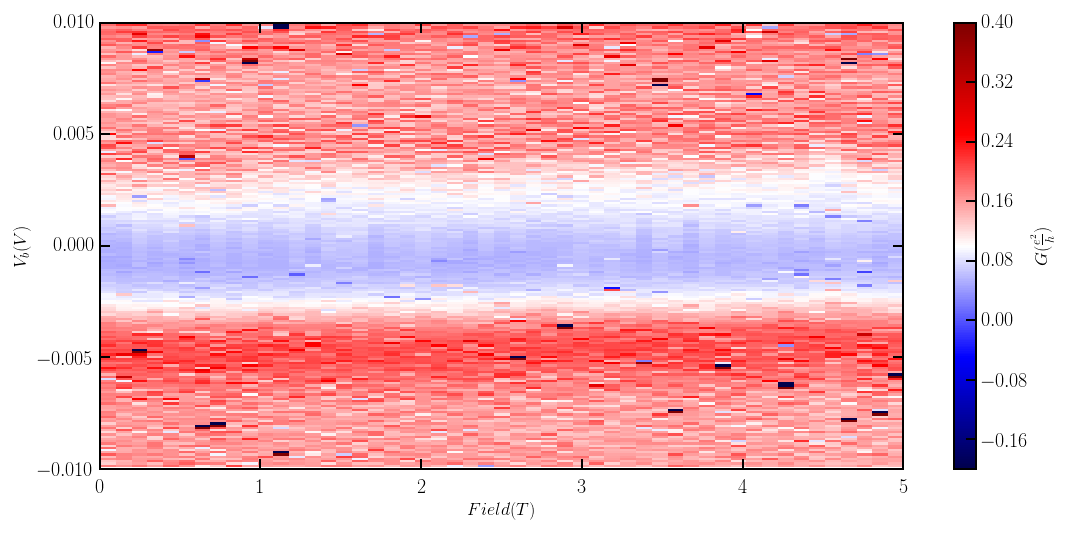

In [50]:
dvdi = (vifield.diff()/75e-6)/3.875e-5

#ddf = pd.rolling_mean(ddf, 2, axis = 1)
#ddf = pd.rolling_mean(ddf, 2, axis = 0)

fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(1,1,1)
limits = lvdt.df_extent(dvdi)
im = ax.imshow(dvdi.iloc[:,0:51], extent = limits, 
           cmap = plt.cm.seismic, vmin = -0.2, vmax = 0.4, 
           origin = 'lower', aspect = 'auto', interpolation = 'Nearest')
#ax.set_title('Py/Py cond')
ax.set_xlabel(r'$Field (T)$')
ax.set_ylabel(r'$V_b (V)$')
#ax.set_ylim(-0.005, 0.005)
cb = plt.colorbar(im)
cb.set_label(r'$G (\frac{e^2}{h})$')

I'm going to go ahead and say nothing happened in the field.

I'm not 100% convinced the field is actually working. There's defintely current going somewhere...

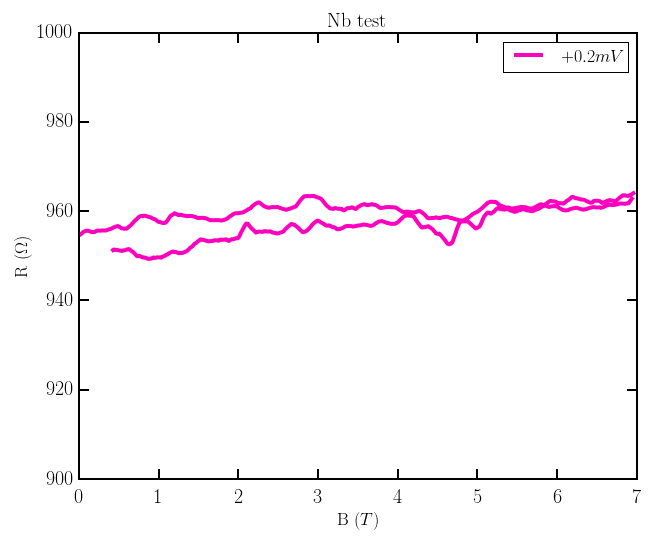

In [52]:
f = data_dir+'fieldswp_4-2-6_4K_b.bin'

data = np.fromfile(f, '>d') # big-endian double point floats

bibias = get_padded_df(data, 'bias')

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

values = np.linspace(1, 0, len(bibias)/2)
cm = plt.get_cmap('gist_rainbow')
ax.set_color_cycle([cm(v) for v in values])

bias = bibias['bias'][0]
field = pd.rolling_mean(bibias.loc[0][40:], 10)
current = pd.rolling_mean(bibias.loc[1][40:], 10)
ax.plot(field, bias/current, label = r'${0:+.1f} mV$'.format(bias*1000))
ax.set_xlim(0,7)
ax.set_ylim(900,1000)
ax.set_title('Nb test')
ax.set_ylabel('R $(\Omega)$')
ax.set_xlabel('B $(T)$')
ax.legend(fontsize = 18)

I was right to suspect the field wasn't on. Apparently, I misunderstood the operation of the persistant switch. Oops. I'm going to take a bunch of this data again.

----

## EVERYTHING ABOVE HERE IS ACTUALLY AT B=0 

----

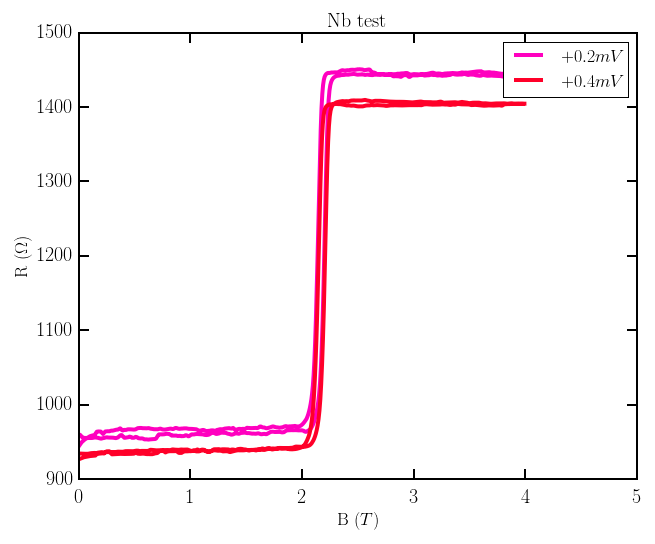

In [53]:
f = data_dir+'fieldswp_4-2-6_4K_c.bin'
data = np.fromfile(f, '>d') # big-endian double point floats

bibias = get_padded_df(data, 'bias')

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

values = np.linspace(1, 0, len(bibias)/2)
cm = plt.get_cmap('gist_rainbow')
ax.set_color_cycle([cm(v) for v in values])

for i in range(0, len(bibias), 2):
    bias = bibias['bias'][i]
    field = pd.rolling_mean(bibias.loc[i][1:], 3)
    current = pd.rolling_mean(bibias.loc[i+1][1:], 3)
    if bias==0.0: #sloppy but fine here
        continue
    ax.plot(field, bias/current, label = r'${0:+.1f} mV$'.format(bias*1000))
ax.set_xlim(0,5)
#ax.set_ylim(0.05,0.2)
ax.set_title('Nb test')
ax.set_ylabel('R $(\Omega)$')
ax.set_xlabel('B $(T)$')
ax.legend(fontsize = 18)

That makes more sense.

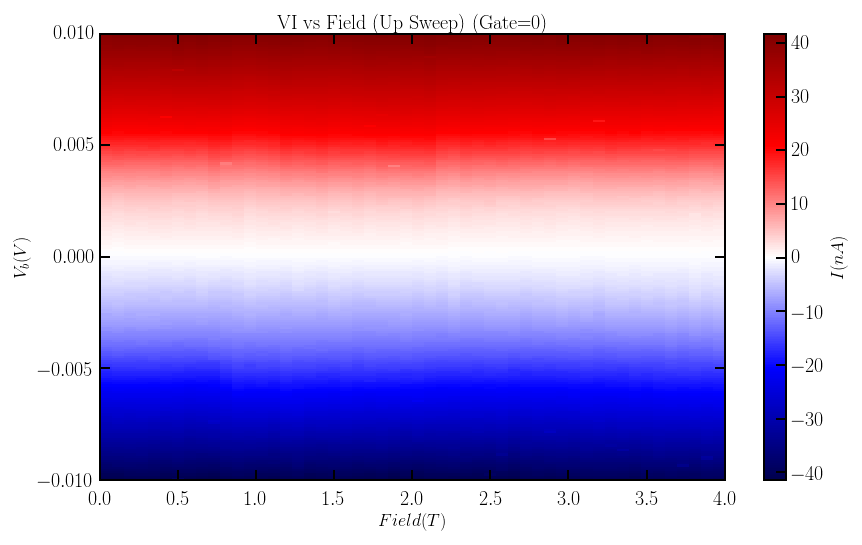

In [56]:
f = data_dir+'vifield_15-16-6_4K_c.bin'

vifield = lvdt.get_data_3d(f)
vifield = vifield.groupby(vifield.index).mean()

fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(1,1,1)
limits = lvdt.df_extent(vifield)
im = ax.imshow(vifield.iloc[:,0:52]*1e9, extent = limits, 
           cmap = plt.cm.seismic, #vmin = -12, vmax = 12,
           origin = 'lower', aspect = 'auto', interpolation = 'None')
ax.set_title('VI vs Field (Up Sweep) (Gate=0)')
ax.set_xlabel(r'$Field (T)$')
ax.set_ylabel(r'$V_b (V)$')
#ax.set_ylim(-0.0025,0.0025)
cb = plt.colorbar(im)
cb.set_label(r'$I (nA)$')

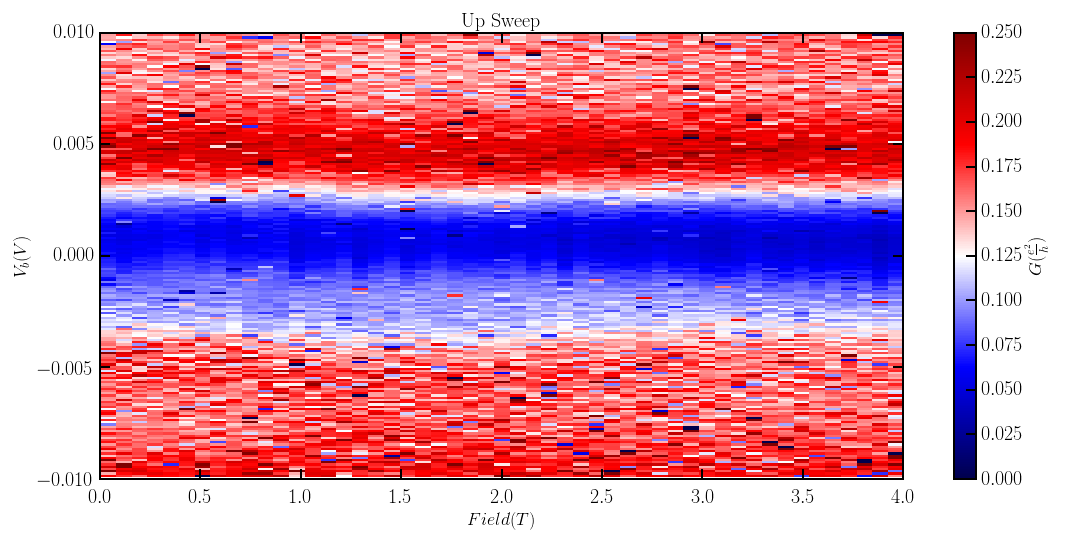

In [61]:
dvdi = (vifield.diff()/75e-6)/3.8755e-5

#ddf = pd.rolling_mean(ddf, 2, axis = 1)
#ddf = pd.rolling_mean(ddf, 2, axis = 0)

fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(1,1,1)
limits = lvdt.df_extent(dvdi)
im = ax.imshow(dvdi.iloc[:,0:51], extent = limits, 
           cmap = plt.cm.seismic, vmin = 0, vmax = 0.25, 
           origin = 'lower', aspect = 'auto', interpolation = 'Nearest')
ax.set_title('Up Sweep')
ax.set_xlabel(r'$Field (T)$')
ax.set_ylabel(r'$V_b (V)$')
#ax.set_ylim(-0.005, 0.005)
cb = plt.colorbar(im)
cb.set_label(r'$G (\frac{e^2}{h})$')

Now that time I'm sure the field was on.

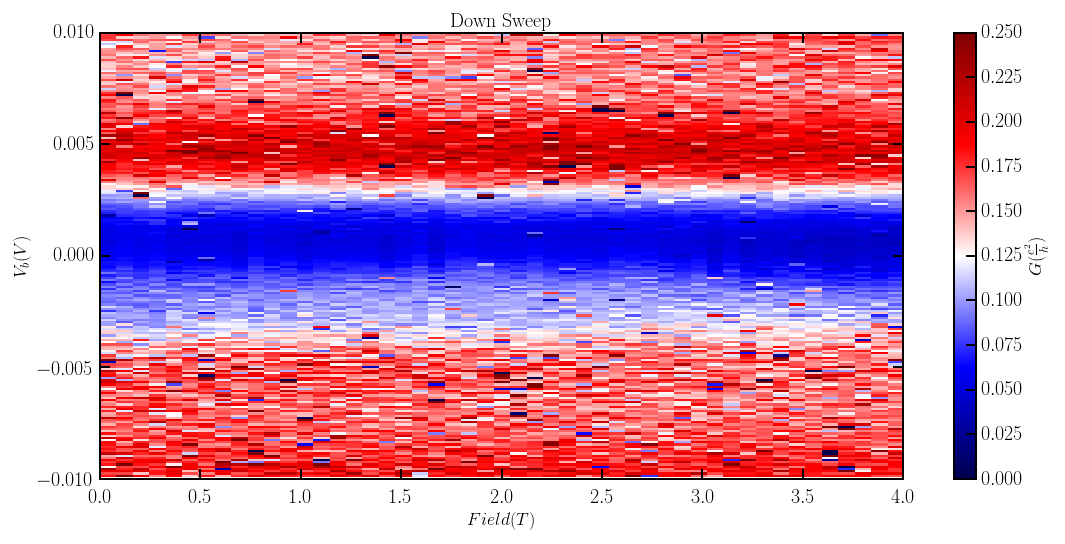

In [62]:
dvdi = (vifield.diff()/75e-6)/3.875e-5

#ddf = pd.rolling_mean(ddf, 2, axis = 1)
#ddf = pd.rolling_mean(ddf, 2, axis = 0)

fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(1,1,1)
limits = lvdt.df_extent(dvdi)
im = ax.imshow(dvdi.iloc[:,:52:-1], extent = limits, 
           cmap = plt.cm.seismic, vmin = 0, vmax = 0.25, 
           origin = 'lower', aspect = 'auto', interpolation = 'Nearest')
ax.set_title('Down Sweep')
ax.set_xlabel(r'$Field (T)$')
ax.set_ylabel(r'$V_b (V)$')
#ax.set_ylim(-0.005, 0.005)
cb = plt.colorbar(im)
cb.set_label(r'$G (\frac{e^2}{h})$')

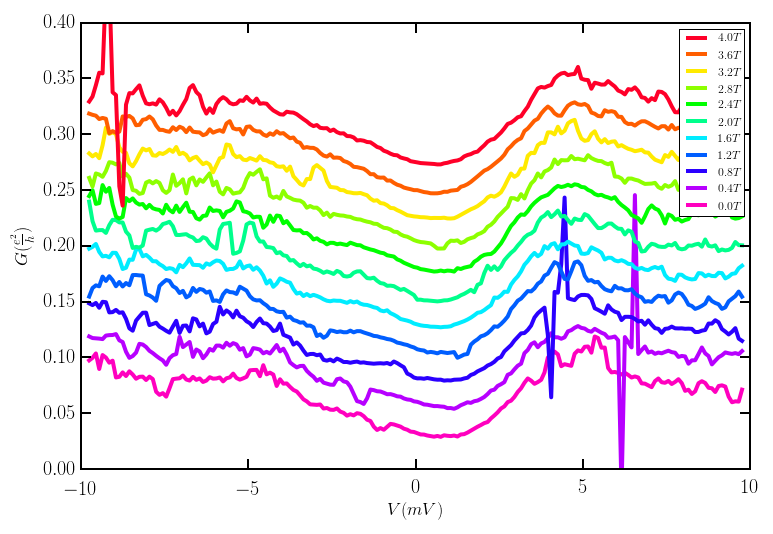

In [63]:
# Here are some cuts across the same data

f = data_dir+'vifield_15-16-6_4K_c.bin'

vifield = lvdt.get_data_3d(f)
vifield = vifield.groupby(vifield.index).mean()
dvdi = (vifield.diff()/75e-6)/7.75e-5

#get just the subset I want...
df = dvdi.iloc[0:200,0:51]

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)

values = np.linspace(1, 0, len(df.columns)/5+1)
cm = plt.get_cmap('gist_rainbow')
ax.set_color_cycle([cm(v) for v in values])

for i in range(0, len(df.columns), 5):
    field = df.columns.values[i]
    bias = pd.rolling_mean(df.index.values, 4)
    cond = pd.rolling_mean(df.iloc[:,i], 4)
    ax.plot(bias*1e3, cond+0.005*i, label = r'${0}T$'.format(field))
ax.set_xlim(-10,10)
ax.set_ylim(0,0.4)
#ax.set_title('fix bias -- sweep field', fontsize=16)
ax.set_ylabel(r'$G (\frac{e^2}{h})$')
ax.set_xlabel(r'$V (mV)$')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1])

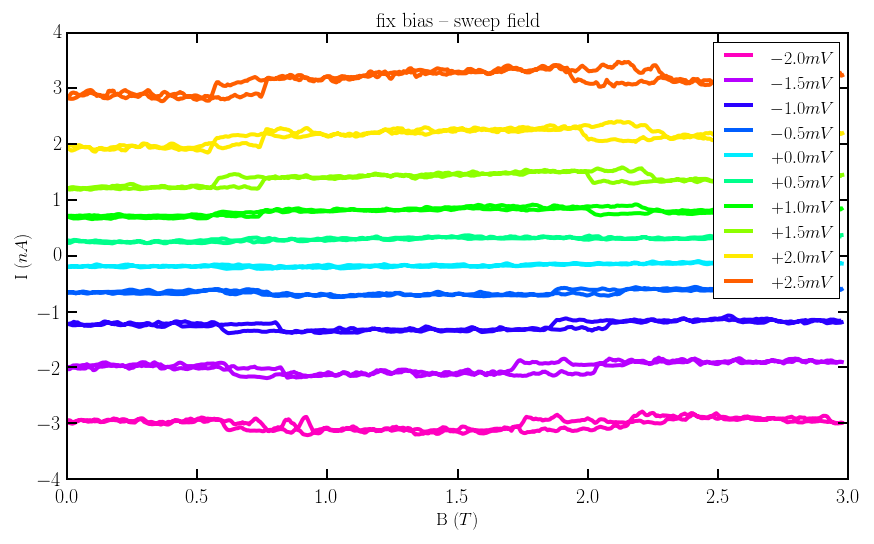

In [64]:
# A different version of that data with the sweep axes switched

f = data_dir+'fieldswp_15-16-6_4K_d.bin'
data = np.fromfile(f, '>d') # big-endian double point floats

bibias = get_padded_df(data, 'bias')

fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(1,1,1)

values = np.linspace(1, 0, len(bibias)/2)
cm = plt.get_cmap('gist_rainbow')
ax.set_color_cycle([cm(v) for v in values])

for i in range(0, len(bibias), 2):
    bias = bibias['bias'][i]
    if (bias==-0.0025): #sloppy but fine here
        continue
    field = pd.rolling_mean(bibias.loc[i][1:], 5)
    current = pd.rolling_mean(bibias.loc[i+1][1:], 5)
    ax.plot(field, current*1e9, label = r'${0:+.1f} mV$'.format(bias*1000))
ax.set_xlim(0,3)
#ax.set_ylim(0.05,0.2)
ax.set_title('fix bias -- sweep field')
ax.set_ylabel(r'I $(nA)$')
ax.set_xlabel(r'B $(T)$')
ax.legend(fontsize = 18)

In [65]:
# make individual subplots with up and down sweeps labelled

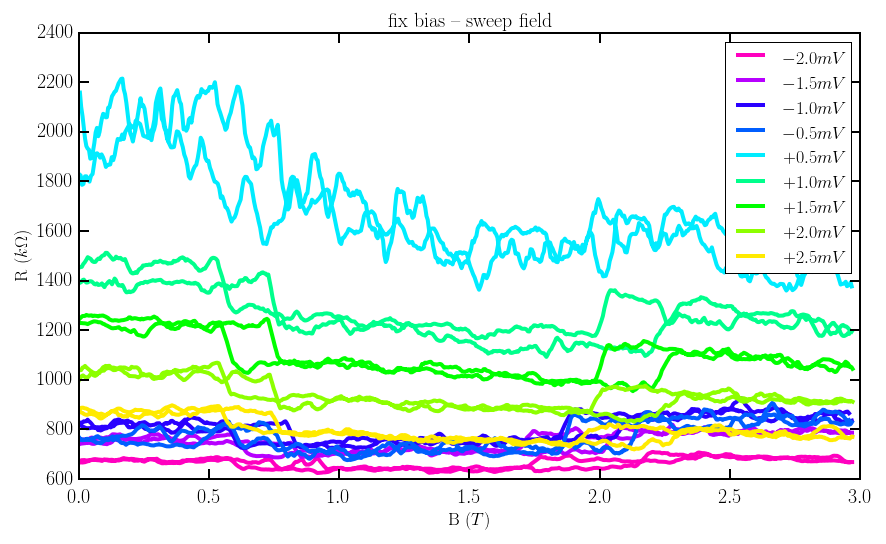

In [66]:
f = data_dir+'fieldswp_15-16-6_4K_d.bin'
data = np.fromfile(f, '>d') # big-endian double point floats

bibias = get_padded_df(data, 'bias')

fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(1,1,1)

values = np.linspace(1, 0, len(bibias)/2)
cm = plt.get_cmap('gist_rainbow')
ax.set_color_cycle([cm(v) for v in values])

for i in range(0, len(bibias), 2):
    bias = bibias['bias'][i]
    field = pd.rolling_mean(bibias.loc[i][1:], 8)
    current = pd.rolling_mean(bibias.loc[i+1][1:], 8)
    if (bias==0.0 or bias==-0.0025): #sloppy but fine here
        continue
    ax.plot(field, (bias/current)/1e3, label = r'${0:+.1f} mV$'.format(bias*1000))
ax.set_xlim(0,3)
#ax.set_ylim(0.05,0.2)
ax.set_title('fix bias -- sweep field')
ax.set_ylabel(r'R $(k\Omega)$')
ax.set_xlabel(r'B $(T)$')
ax.legend(fontsize = 18)

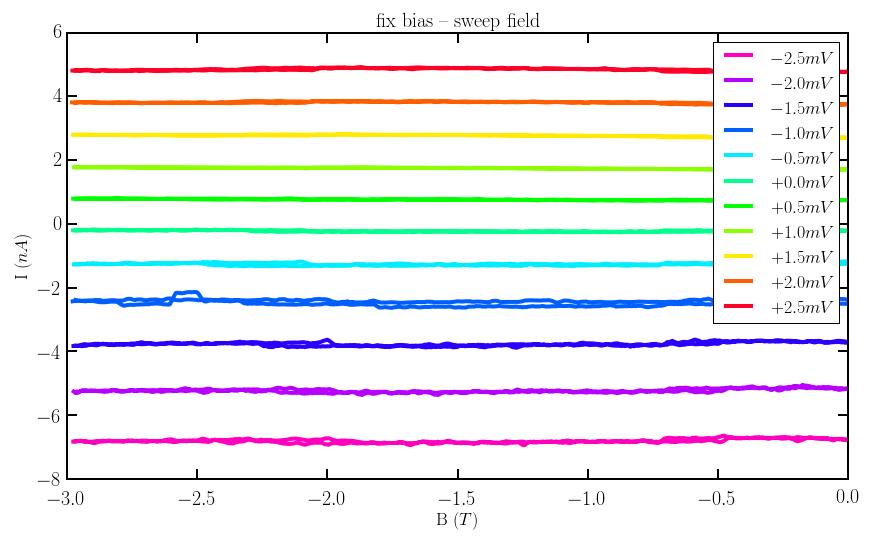

In [73]:
# same data, negative field

f = data_dir+'fieldswp_15-16-6_4K_h.bin'
data = np.fromfile(f, '>d') # big-endian double point floats

bibias = get_padded_df(data, 'bias')

fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(1,1,1)

values = np.linspace(1, 0, len(bibias)/2)
cm = plt.get_cmap('gist_rainbow')
ax.set_color_cycle([cm(v) for v in values])

for i in range(0, len(bibias), 2):
    bias = bibias['bias'][i]
    field = -pd.rolling_mean(bibias.loc[i][1:], 5)
    current = pd.rolling_mean(bibias.loc[i+1][1:], 5)
    ax.plot(field, current*1e9, label = r'${0:+.1f} mV$'.format(bias*1000))
ax.set_xlim(-3, 0)
#ax.set_ylim(0.05,0.2)
ax.set_title('fix bias -- sweep field')
ax.set_ylabel(r'I $(nA)$')
ax.set_xlabel(r'B $(T)$')
ax.legend(fontsize = 18)

In [ ]:
# make individual subplots with up and down sweeps labelled

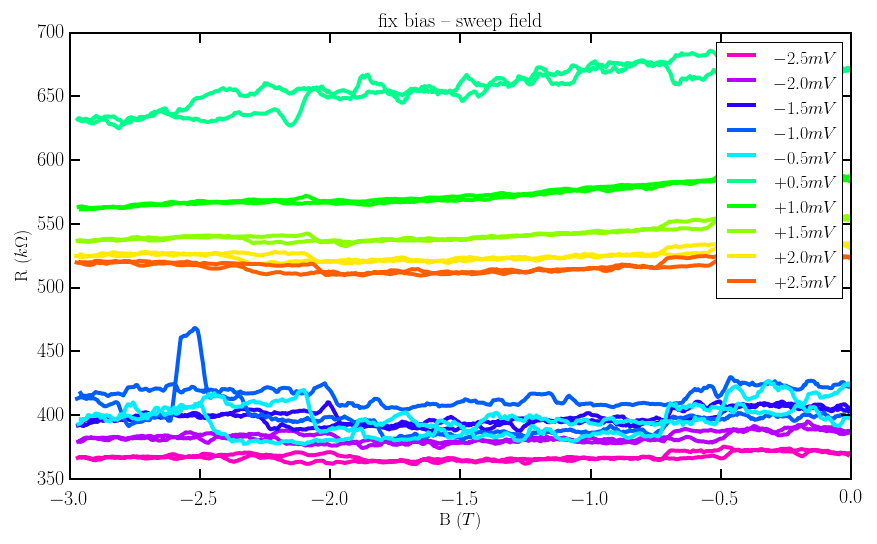

In [104]:
f = data_dir+'fieldswp_15-16-6_4K_h.bin'
data = np.fromfile(f, '>d') # big-endian double point floats

bibias = get_padded_df(data, 'bias')

fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(1,1,1)

values = np.linspace(1, 0, len(bibias)/2)
cm = plt.get_cmap('gist_rainbow')
ax.set_color_cycle([cm(v) for v in values])

for i in range(0, len(bibias), 2):
    bias = bibias['bias'][i]
    field = -pd.rolling_mean(bibias.loc[i][1:], 8)
    current = pd.rolling_mean(bibias.loc[i+1][1:], 8)
    if (bias==0.0): #sloppy but fine here
        continue
    ax.plot(field, (bias/current)/1e3, label = r'${0:+.1f} mV$'.format(bias*1000))
ax.set_xlim(-3,0)
#ax.set_ylim(0.05,0.2)
ax.set_title('fix bias -- sweep field')
ax.set_ylabel(r'R $(k\Omega)$')
ax.set_xlabel(r'B $(T)$')
ax.legend(fontsize = 18)

The switching went in the opposite direction for the 0.5mV sweep. Also, the whole device seems to have changed resistance. I think the gate is not stable. That's not too surprising given that it's shorted somewhere. Here is another sweep of the bias and field, this time a little faster and with negative field.

In [77]:
f = data_dir+'vifield_15-16-6_4K_d.bin'

There are no Py/Py dots that are alive on this device anymore. (I think the really narrow Py leads were too small to survive.) There is an Nb/Nb dot alive. I'm going to check this same measurement on that.

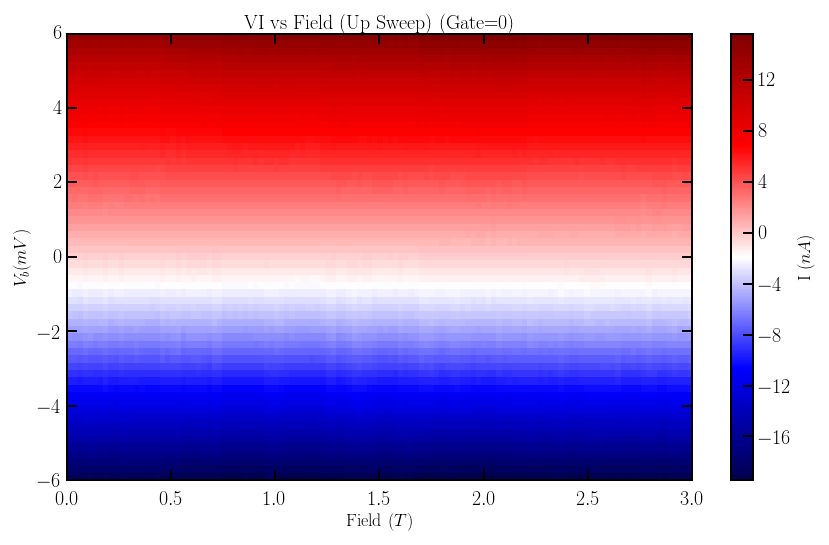

In [89]:
# fix the field labels here
# field goes from 0 to 3T to 0T

f = data_dir+'vifield_15-16-6_4K_d.bin'

vifield = lvdt.get_data_3d(f)
vifield = vifield.groupby(vifield.index).mean()

fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(1,1,1)
#limits = lvdt.df_extent(vifield)
im = ax.imshow(vifield.iloc[:,0:121]*1e9, extent = [0,3,-6,6], 
           cmap = plt.cm.seismic, #vmin = -12, vmax = 12,
           origin = 'lower', aspect = 'auto', interpolation = 'nearest')
ax.set_title('VI vs Field (Up Sweep) (Gate=0)')
ax.set_xlabel('Field $(T)$')
ax.set_ylabel('$V_b (mV)$')
#ax.set_ylim(-0.0025,0.0025)
cb = plt.colorbar(im)
cb.set_label('I $(nA)$')

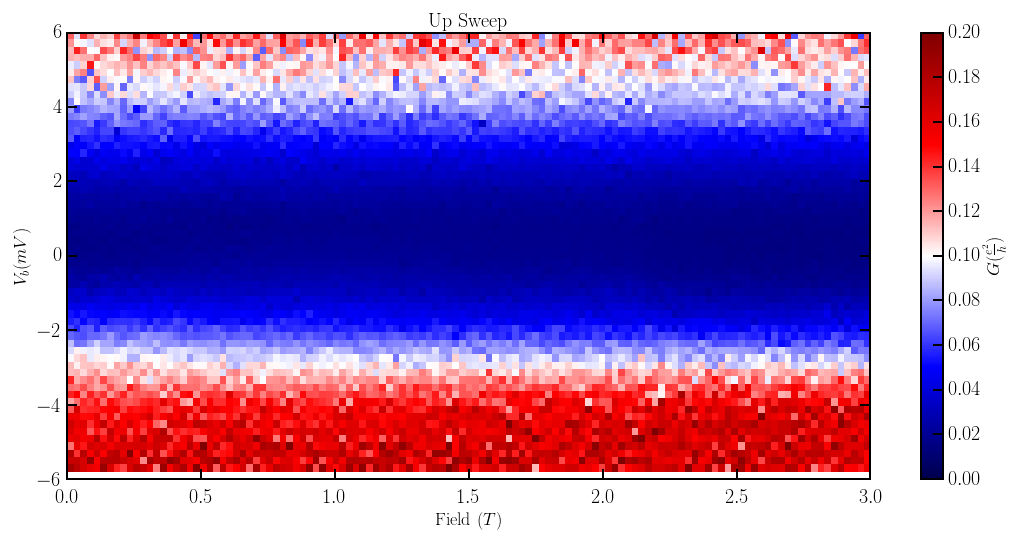

In [106]:
dvdi = (vifield.diff()/75e-6)/3.875e-5

#ddf = pd.rolling_mean(ddf, 2, axis = 1)
#ddf = pd.rolling_mean(ddf, 2, axis = 0)

fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(1,1,1)
#limits = lvdt.df_extent(dvdi)
im = ax.imshow(dvdi.iloc[:,0:121], extent = [0,3,-6,6], 
           cmap = plt.cm.seismic, vmin = 0, vmax = 0.2, 
           origin = 'lower', aspect = 'auto', interpolation = 'Nearest')
ax.set_title('Up Sweep')
ax.set_xlabel('Field $(T)$')
ax.set_ylabel('$V_b (mV)$')
#ax.set_ylim(-0.005, 0.005)
cb = plt.colorbar(im)
cb.set_label(r'$G (\frac{e^2}{h})$')

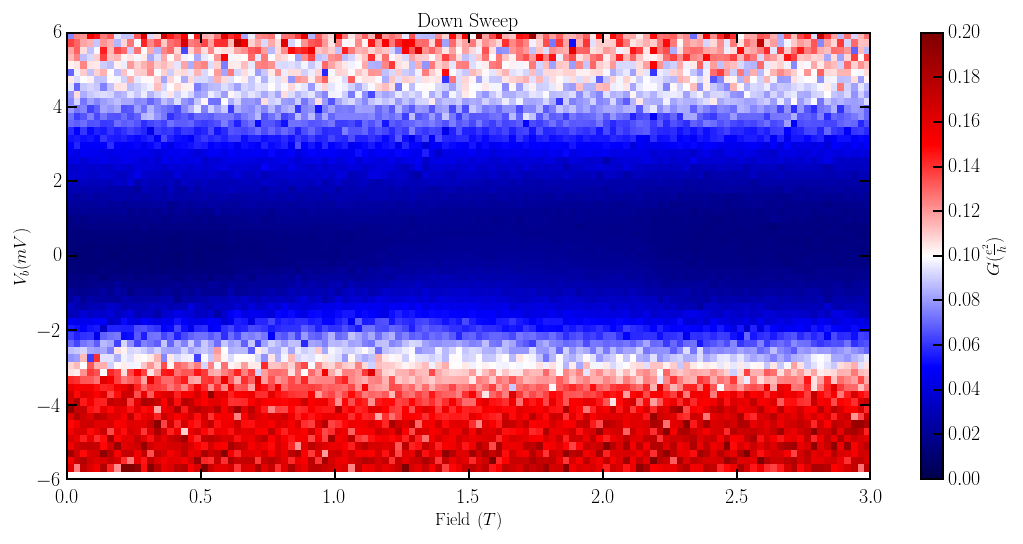

In [107]:
dvdi = (vifield.diff()/75e-6)/3.875e-5

#ddf = pd.rolling_mean(ddf, 2, axis = 1)
#ddf = pd.rolling_mean(ddf, 2, axis = 0)

fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(1,1,1)
#limits = lvdt.df_extent(dvdi)
im = ax.imshow(dvdi.iloc[:,:121:-1], extent = [0,3,-6,6], 
           cmap = plt.cm.seismic, vmin = 0, vmax = 0.2, 
           origin = 'lower', aspect = 'auto', interpolation = 'Nearest')
ax.set_title('Down Sweep')
ax.set_xlabel('Field $(T)$')
ax.set_ylabel('$V_b (mV)$')
#ax.set_ylim(-0.005, 0.005)
cb = plt.colorbar(im)
cb.set_label(r'$G (\frac{e^2}{h})$')

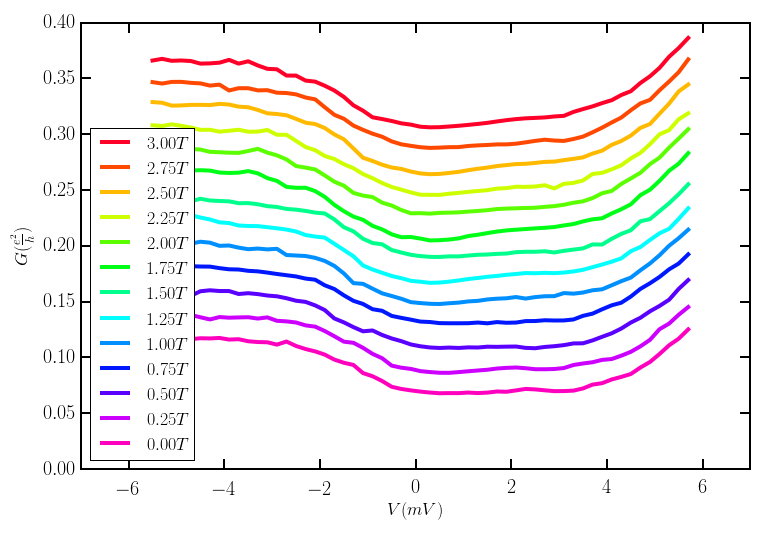

In [94]:
# Here are some cuts across the same data

f = data_dir+'vifield_15-16-6_4K_d.bin'

vifield = lvdt.get_data_3d(f)
vifield = vifield.groupby(vifield.index).mean()
dvdi = (vifield.diff()/75e-6)/7.75e-5

#get just the subset I want...
df = dvdi.iloc[:,0:121] # up sweep

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)

values = np.linspace(1, 0, len(df.columns)/10+1)
cm = plt.get_cmap('gist_rainbow')
ax.set_color_cycle([cm(v) for v in values])

for i in range(0, len(df.columns), 10):
    field = df.columns.values[i]
    bias = pd.rolling_mean(df.index.values, 4)
    cond = pd.rolling_mean(df.iloc[:,i], 4)
    ax.plot(bias*1e3, cond+0.002*i , label = r'${0:.2f}T$'.format(field))
ax.set_xlim(-7,7)
ax.set_ylim(0,0.4)
#ax.set_title('fix bias -- sweep field', fontsize=16)
ax.set_ylabel(r'$G (\frac{e^2}{h})$')
ax.set_xlabel(r'$V (mV)$')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], fontsize = 18, loc='lower left')

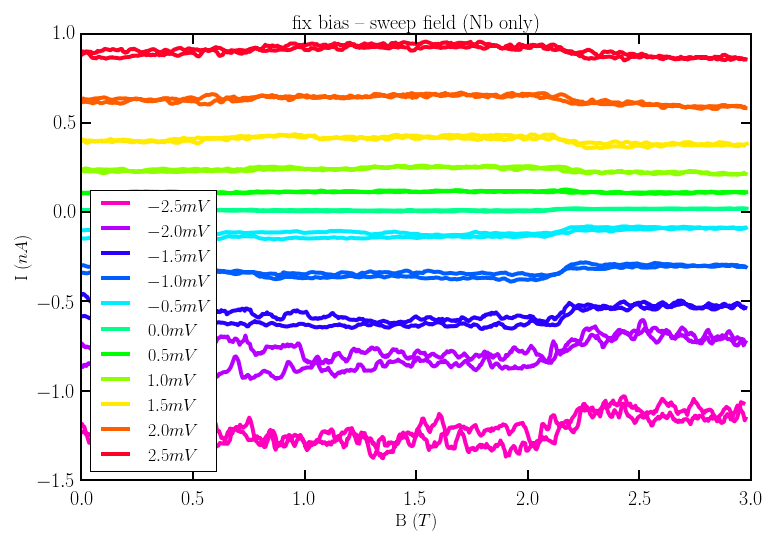

In [95]:
f = data_dir+'fieldswp_2-1-6_4K_a.bin'

data = np.fromfile(f, '>d') # big-endian double point floats

bibias = get_padded_df(data, 'bias')

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)

values = np.linspace(1, 0, len(bibias)/2)
cm = plt.get_cmap('gist_rainbow')
ax.set_color_cycle([cm(v) for v in values])

for i in range(0, len(bibias), 2):
    bias = bibias['bias'][i]
    field = pd.rolling_mean(bibias.loc[i][1:], 5)
    current = pd.rolling_mean(bibias.loc[i+1][1:], 5)
    ax.plot(field, current*1e9, label = r'${0:.1f} mV$'.format(bias*1000))
ax.set_xlim(0,3)
#ax.set_ylim(0.05,0.2)
ax.set_title('fix bias -- sweep field (Nb only)')
ax.set_ylabel('I $(nA)$')
ax.set_xlabel('B $(T)$')
ax.legend(loc = 'lower left', fontsize = 18)

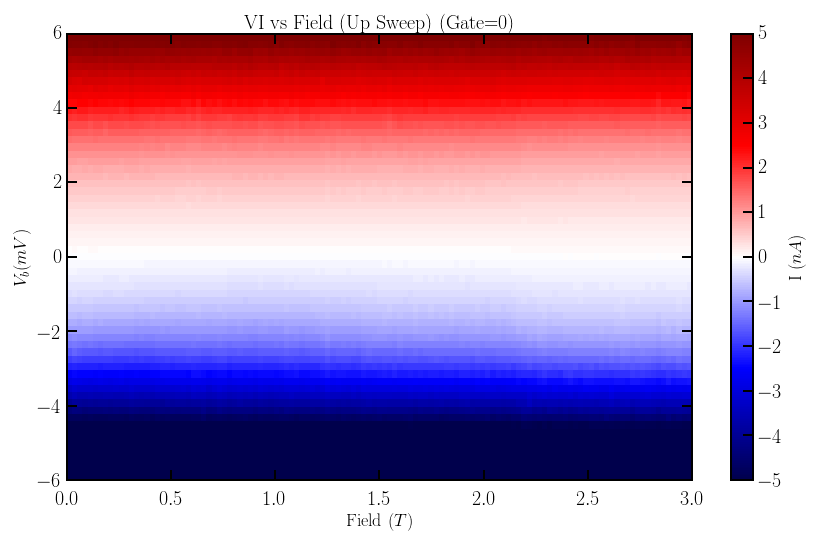

In [110]:
f = data_dir+'vifield_2-1-6_4K_a.bin'

vifield = lvdt.get_data_3d(f)
vifield = vifield.groupby(vifield.index).mean()

fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(1,1,1)
#limits = lvdt.df_extent(vifield)
im = ax.imshow(vifield.iloc[:,0:121]*1e9, extent = [0,3,-6,6], 
           cmap = plt.cm.seismic, vmin = -5, vmax = 5,
           origin = 'lower', aspect = 'auto', interpolation = 'None')
ax.set_title('VI vs Field (Up Sweep) (Gate=0)')
ax.set_xlabel('Field $(T)$')
ax.set_ylabel('$V_b (mV)$')
#ax.set_ylim(-0.0025,0.0025)
cb = plt.colorbar(im)
cb.set_label('I $(nA)$')

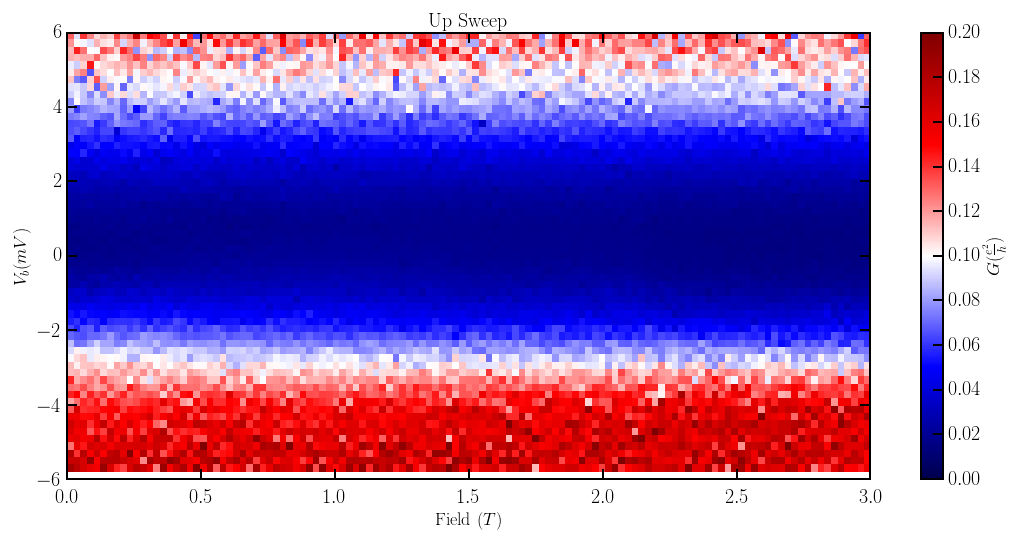

In [112]:
dvdi = (vifield.diff()/75e-6)/3.875e-5

#ddf = pd.rolling_mean(ddf, 2, axis = 1)
#ddf = pd.rolling_mean(ddf, 2, axis = 0)

fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(1,1,1)
#limits = lvdt.df_extent(dvdi)
im = ax.imshow(dvdi.iloc[:,0:121], extent = [0,3,-6,6], 
           cmap = plt.cm.seismic, vmin = 0, vmax = 0.2, 
           origin = 'lower', aspect = 'auto', interpolation = 'Nearest')
ax.set_title('Up Sweep')
ax.set_xlabel('Field $(T)$')
ax.set_ylabel('$V_b (mV)$')
#ax.set_ylim(-0.005, 0.005)
cb = plt.colorbar(im)
cb.set_label(r'$G (\frac{e^2}{h})$')

Trying to sort through the data that matters...

In [113]:
def get_sweep_direction(a):
    if np.diff(a).mean() > 0:
        return 1
    else:
        return -1

def get_single_sweep(field, current):
    inds = np.where(field == np.inf)[0][0:2]
    one = np.dstack((field[0:inds[0]], current[0:inds[0]]))[0]
    two = np.dstack((field[inds[0]+1:inds[1]], current[inds[0]+1:inds[1]]))[0]
    if get_sweep_direction(one) > 0:
        return one, two # up sweep first
    else:
        return two, one # up sweep first

In [115]:
# leads 15(+)(Py)->16(-)(Nb)
p = data_dir+'fieldswp_15-16-6_4K_d.bin' # fix bias sweep field from 0->3T 
n = data_dir+'fieldswp_15-16-6_4K_h.bin' # fix bias sweep field from 0->-3T

# leads 2(+)(Nb)->1(-)(Nb)
s = data_dir+'fieldswp_2-1-6_4K_a.bin'# fix bias sweep fielf from 0->3T

# shorted Nb leads to check transition
t = data_dir+'fieldswp_4-2-6_4K_c.bin'

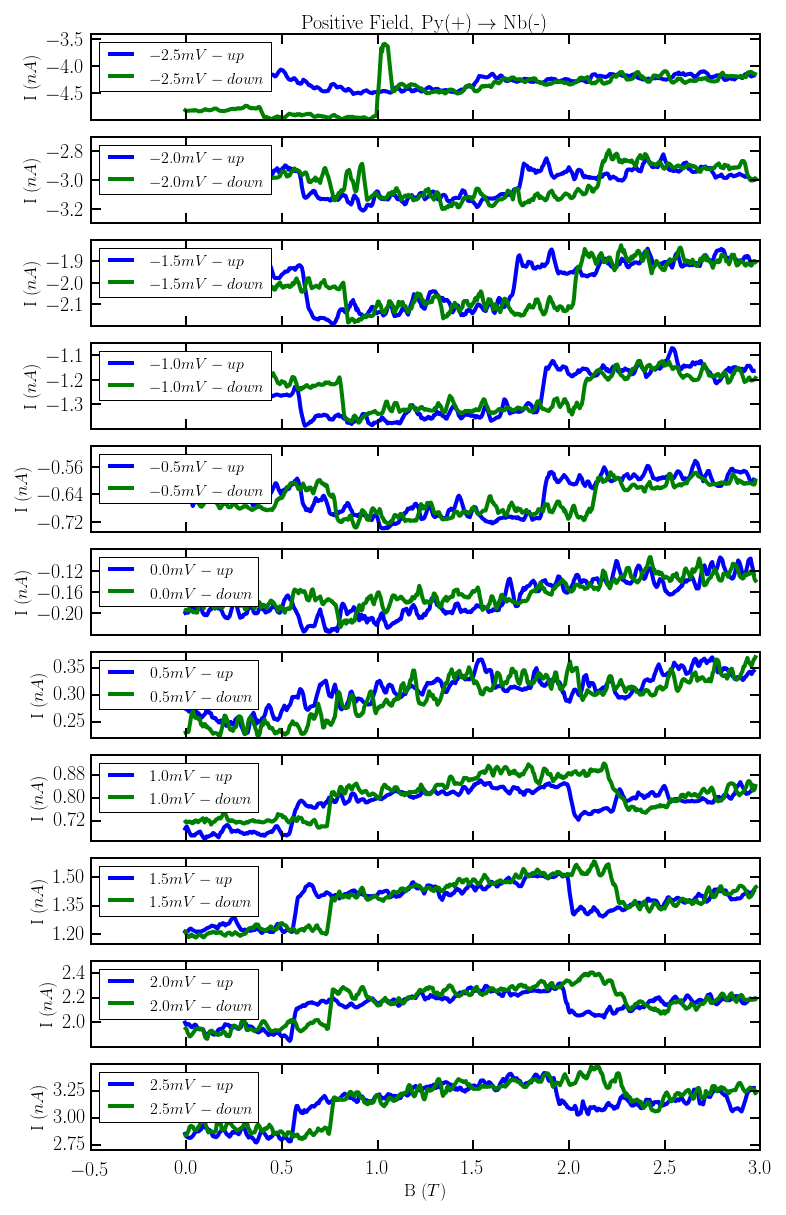

In [142]:
# positive field Py/Nb leads
data = np.fromfile(p, '>d') # big-endian double point floats
df = get_padded_df(data, 'bias')

from matplotlib.ticker import MaxNLocator

fig, axs = plt.subplots(len(df)/2,1,sharex = True, sharey=False, 
                        figsize=(12,20))
axs = axs.flat
#fig.subplots_adjust(hspace=.5)

axs[0].set_title(r'Positive Field, Py(+) $\rightarrow$ Nb(-)')
for i in range(len(df)/2):
    bias = df['bias'][2*i]
    field = df.iloc[2*i,1:]
    current = df.iloc[2*i+1,1:]
    up,down = get_single_sweep(field, current)
    up = pd.rolling_mean(up, 5)
    down = pd.rolling_mean(down, 5)
    axs[i].plot(up[:,0], up[:,1]*1e9, c = 'b',
                label = r'${0:.1f}mV - up$'.format(bias*1e3))
    axs[i].plot(down[:,0], down[:,1]*1e9, c = 'g',
                label = r'${0:.1f}mV - down$'.format(bias*1e3))
    axs[i].yaxis.set_major_locator(MaxNLocator (nbins = 4, prune = 'both'))
    axs[i].set_ylabel('I $(nA)$')
    axs[i].legend(loc = 'upper left', fontsize = 16)
    
#ax.set_xlim(0,3)
#ax.set_title('sweep direction test')
axs[-1].set_xlabel('B $(T)$')
#ax.set_ylabel('I $(nA)$')

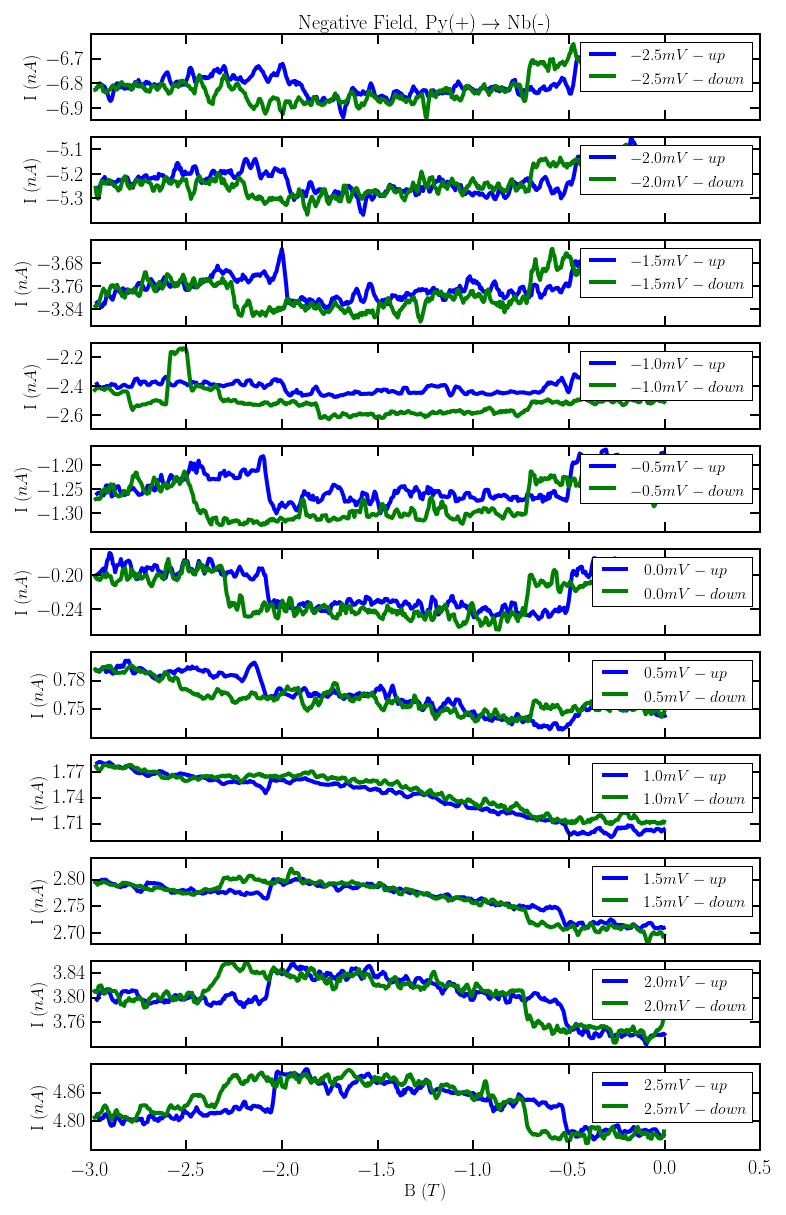

In [141]:
# negative field Py/Nb leads
data = np.fromfile(n, '>d') # big-endian double point floats
df = get_padded_df(data, 'bias')


fig, axs = plt.subplots(len(df)/2,1,sharex = True, sharey=False, 
                        figsize=(12,20))
axs = axs.flat

axs[0].set_title(r'Negative Field, Py(+) $\rightarrow$ Nb(-)')
for i in range(len(df)/2):
    bias = df['bias'][2*i]
    field = df.iloc[2*i,1:]
    current = df.iloc[2*i+1,1:]
    up,down = get_single_sweep(field, current)
    up = pd.rolling_mean(up, 5)
    down = pd.rolling_mean(down, 5)
    axs[i].plot(-1.0*up[:,0], up[:,1]*1e9, c = 'b',
                label = r'${0:.1f}mV - up$'.format(bias*1e3))
    axs[i].plot(-1.0*down[:,0], down[:,1]*1e9, c = 'g',
                label = r'${0:.1f}mV - down$'.format(bias*1e3))
    axs[i].yaxis.set_major_locator(MaxNLocator (nbins = 4, prune = 'both'))
    axs[i].set_ylabel('I $(nA)$')
    axs[i].legend(loc = 'upper right', fontsize = 16)
    
#ax.set_xlim(0,3)
#ax.set_title('sweep direction test')
axs[-1].set_xlabel('B $(T)$')
#ax.set_ylabel('I $(nA)$')

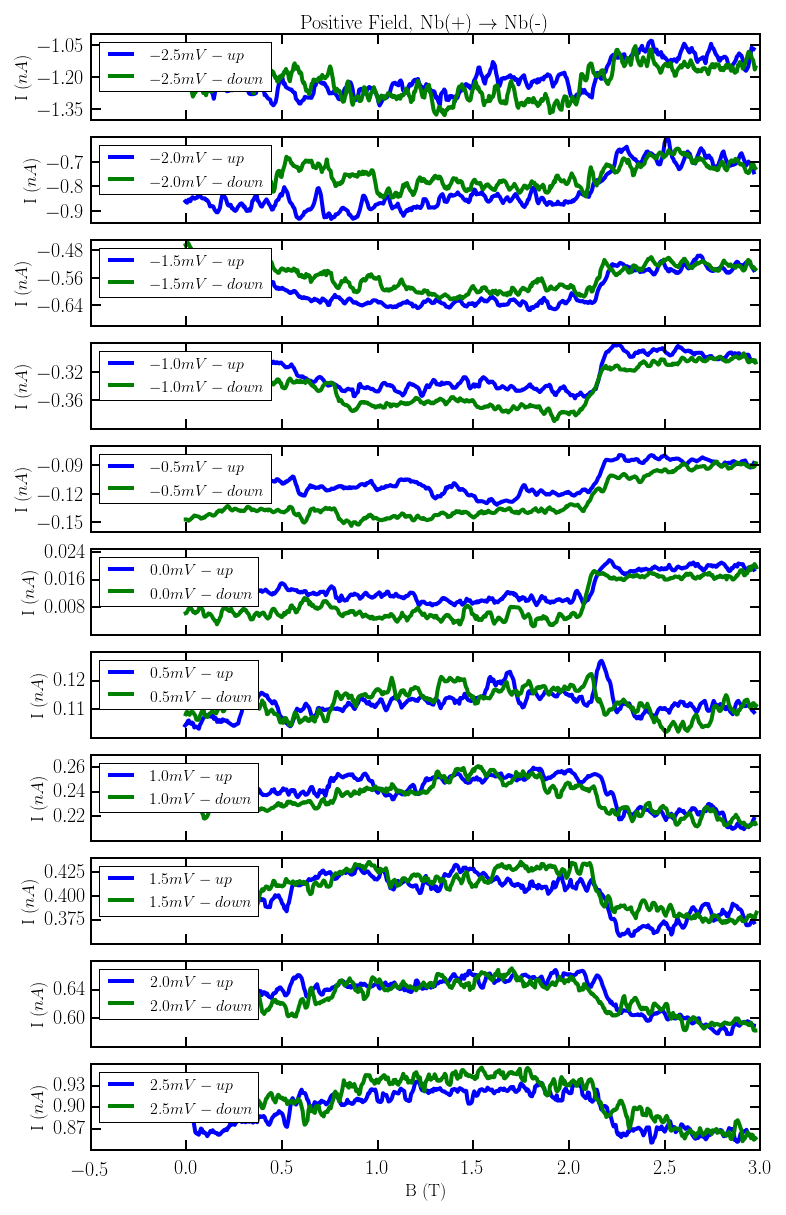

In [140]:
# positive field Nb/Nb leads
data = np.fromfile(s, '>d') # big-endian double point floats
df = get_padded_df(data, 'bias')


fig, axs = plt.subplots(len(df)/2,1,sharex = True, sharey=False, 
                        figsize=(12,20))
axs = axs.flat

axs[0].set_title(r'Positive Field, Nb(+) $\rightarrow$ Nb(-)')
for i in range(len(df)/2):
    bias = df['bias'][2*i]
    field = df.iloc[2*i,1:]
    current = df.iloc[2*i+1,1:]
    up,down = get_single_sweep(field, current)
    up = pd.rolling_mean(up, 5)
    down = pd.rolling_mean(down, 5)
    axs[i].plot(up[:,0], up[:,1]*1e9, c = 'b',
                label = r'${0:.1f}mV - up$'.format(bias*1e3))
    axs[i].plot(down[:,0], down[:,1]*1e9, c = 'g',
                label = r'${0:.1f}mV - down$'.format(bias*1e3))
    axs[i].yaxis.set_major_locator(MaxNLocator (nbins = 4, prune = 'both'))
    axs[i].set_ylabel('I $(nA)$')
    axs[i].legend(loc = 'upper left', fontsize = 16)
    
#ax.set_xlim(0,3)
#ax.set_title('sweep direction test')
axs[-1].set_xlabel('B (T)')
#ax.set_ylabel('I (nA)')

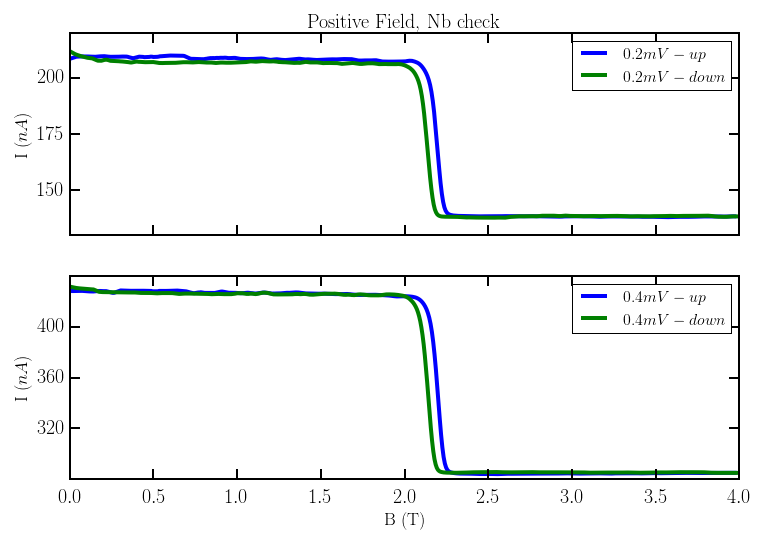

In [139]:
# positive field Nb leads
data = np.fromfile(t, '>d') # big-endian double point floats
df = get_padded_df(data, 'bias')


fig, axs = plt.subplots(len(df)/2,1,sharex = True, sharey=False, 
                        figsize=(12,8))
axs = axs.flat

axs[0].set_title(r'Positive Field, Nb check')
for i in range(len(df)/2):
    bias = df['bias'][2*i]
    field = df.iloc[2*i,1:]
    current = df.iloc[2*i+1,1:]
    up,down = get_single_sweep(field, current)
    up = pd.rolling_mean(up, 5)
    down = pd.rolling_mean(down, 5)
    axs[i].plot(up[:,0], up[:,1]*1e9, c = 'b',
                label = r'${0:.1f}mV - up$'.format(bias*1e3))
    axs[i].plot(down[:,0], down[:,1]*1e9, c = 'g',
                label = r'${0:.1f}mV - down$'.format(bias*1e3))
    axs[i].yaxis.set_major_locator(MaxNLocator (nbins = 4, prune = 'both'))
    axs[i].set_ylabel('I $(nA)$')
    axs[i].legend(loc = 'upper right', fontsize = 16)
    
#ax.set_xlim(0,3)
#ax.set_title('sweep direction test')
axs[-1].set_xlabel('B (T)')
#ax.set_ylabel('I (nA)')